In [1]:
import numpy as np
from scipy.stats import norm
from scipy.special import expit
import matplotlib.pyplot as plt
from IPython.display import HTML
from Visualization import plot_borders, animate
from itertools import product
from CellModels import *
from Drawing import line, trajectory
import matplotlib.animation

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['font.family'] = 'Times New Roman'

In [2]:
def rand_merge(z, c_type, c_rep, replace=False, kind='ari'):
    n_type, n_rep = z.shape[:2]
    if n_type < c_type:
        raise ValueError
    if n_rep < c_rep:
        raise ValueError
        
    idx_type = np.random.choice(np.arange(0, n_type), size=c_type, replace=replace)
    out = np.ones(z.shape[2:])
    for i in idx_type:
        idx_rep = np.random.choice(np.arange(0, n_rep), size=c_rep, replace=replace)
        if kind == 'geo':
            out *= np.prod(z[i, idx_rep], axis=0)
        elif kind == 'ari':
            out += np.sum(z[i, idx_rep], axis=0)
        else: 
            raise ValueError
    if kind == 'geo':
        out **= 1/c_type/c_rep # Geometric mean
    elif kind == 'ari':
        out /= c_type / c_rep # Arithmetic mean
    
    omax, omin = out.max(), out.min()
    out = (out - omin) / (omax - omin) # Normalization
    return out

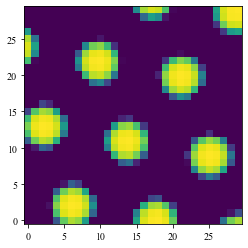

In [3]:
g = Grid2D_NNN(n=30, r=0.8, psy=0.7, phi=np.random.rand()*np.pi, s=0.6)
s = g(np.ones((100, 2)), 0.1)
plt.imshow(s[0, 0], origin='lower')

In [4]:
l = []
l.append(line([0, 0], [0, 2], num=50) - 1)
l.append(line([0, 2], [1, 2], num=50) - 1)
l.append(line([1, 2], [2, 2], num=50) - 1)
l.append(line([2, 2], [2, 0], num=50) - 1)
l.append(line([2, 0], [0, 0], num=50) - 1)
l.append(line([1, 1], [1, 2], num=50) - 1)

T = 5000

# x, v, hd = trajectory(np.pi/3, 0.1, T, l, [-0.5, 0])
    
# g = Grid2DR(n=30, r=0.8, psy=0.7, phi=np.random.rand()*np.pi, s=0.4)
# s = g(v, 1)

In [5]:
# plot_borders(l)

# for i in range(s.shape[0]):
#     c = s[i, 0, 15, 15]
#     plt.plot(x[i:i+2, 0],x[i:i+2, 1],color=(c, 1-c, 1-c))

In [6]:
x, v, hd = trajectory(np.pi/3, 0.1, T, l, [-0.5, 0])

n = 30
alphas = [0.2, 0.4, 0.8, 1.6, 3.2]
g = Grid2D_NNN(n=n, r=0.8, psy=np.random.rand()*np.pi/3,
               phi=np.random.rand(), s=0.4)
s_g = g(v, alphas)

dist_pref = np.array([0.4, 0.3, 0.2, 0.1])
dir_pref = np.linspace(np.pi, -np.pi, 8, endpoint=False)
bs = ABVC2D(dist_pref, dir_pref, 5, 0.1, np.pi/4)
s_b, vis = bs(x, hd, l)

s_b.max(), s_b.min(), s_g.max(), s_g.min()

(1.0, 2.138145411869201e-10, 1.0, 0.0)

In [7]:
class Place_Patch_CANN:
    def __init__(self, n, rank, tau, lam, a, c0, c1):
        '''
        Parameters
        ----------
        n : int
            Number of place cells
        rank : int
            Number of grid ensembles each place cell ensemble connects with
        '''
        self.n, self.rank, self.tau = n, rank, tau
        self.beta_i = 1/lam**2
        self.beta_e = self.beta_i * c0
        
        x = np.linspace(-n/2, n/2, num=n, endpoint=False)
        dist = np.abs(x[:, None] - x[None, :])
        dist[dist > n/2] = n - dist[dist > n/2]
        dist = dist**2
        self.W = c1 * (a * np.exp(-self.beta_e * dist) - np.exp(-self.beta_i * dist))

    def __call__(self, bvcs, grids):
        '''
        Parameters
        ----------
        bvcs : np.ndarray
            (T, d, alpha)
        grids : np.ndarray
            (T, n, n) or (T, len(grid_alphas), redundancy, n, n)
        '''
        T = len(bvcs)
        if len(grids.shape) == 3: # (T, n, n) -> (T, len(alphas), r*r, n, n)
            grids = grids[:, None, None, ...]

        s = np.zeros((T, self.n))

        # Each place ensemble receives from a subset of grid ensembles
        idx_pool = np.arange(grids.shape[1])
        idx_g_ensmbl = np.zeros((self.n, self.rank), dtype=np.int32)
        for i in range(self.n):
            idx_g_ensmbl[i] = np.random.choice(idx_pool, size=self.rank,
                                               replace=False)

        g_n = grids.shape[3]
        patch_starts = np.random.randint(0, g_n-3, size=(self.n, 2))
        
        for t in range(1, T):
            ds = np.zeros(self.n)
            for i in range(self.n):
                comp = grids[t, idx_g_ensmbl[i]].mean(axis=(0, 1)) - 0.6
                pi, qi = patch_starts[i]
                pj, qj = min(pi+3, g_n-1), min(qi+3, g_n-1)
                ds[i] = comp[pi:pj, qi:qj].mean()
            ds += self.W @ s[t-1]
            ds[ds < 0] = 0
            ds = ds - s[t-1]

            s[t] = s[t-1] + ds / self.tau
        return s, idx_g_ensmbl

In [8]:
# pc = Place(50, 3, 5, 20, 1, 1.5, 1)
# s_p, idx_g_ensmbl = pc(s_b, s_g)

In [9]:
class Place_DoG:
    def __init__(self, n, rank, tau, lam, a, c0, c1=1):
        '''
        Parameters
        ----------
        n : int
            Number of place cells along each axis
        rank : int
            Number of grid ensembles each place cell ensemble connects with
        '''
        self.n, self.rank, self.tau = n, rank, tau
        self.N = n**2
        self.beta_i = 1/lam**2
        self.beta_e = self.beta_i * c0
        
        aux = np.linspace(-n/2, n/2, num=n, endpoint=False)
        x = np.stack(np.meshgrid(aux, aux), axis=-1).reshape(self.N, 2)
        dist = np.abs(x[:, None] - x[None, :])
        dist[dist > n/2] = n - dist[dist > n/2]
        dist = np.linalg.norm(dist, axis=-1)**2
        self.W = a * np.exp(-self.beta_e * dist) - np.exp(-self.beta_i * dist)
        self.W *= c1 / np.linalg.norm(self.W, axis=-1)[:, None]
        

    def __call__(self, bvcs, grids, eta=1e-3):
        '''
        Parameters
        ----------
        bvcs : np.ndarray
            (T, d, bvc_alpha)
        grids : np.ndarray
            (T, n_g, n_g) or (T, len(grid_alphas), redundancy, n_g, n_g)
        '''
        T = len(bvcs)
        if len(grids.shape) == 3: # (T, n, n) -> (T, len(alphas), r*r, n, n)
            grids = grids[:, None, None, ...]

        s = np.zeros((T, self.N))

        W_b = np.random.rand(self.N, *bvcs.shape[1:])
        # V1: shared weights, so W_g with shape (n, n_g, n_g)
        W_g = np.random.rand(self.N, *grids.shape[-2:]) 
        # V2: Sep. weights, so W_g with shape (n, rank, redun, n_g, n_g)
#         W_g = np.random.rand(self.N, self.rank, *grids.shape[2:]) 
        
        # Each place ensemble receives from a subset of grid ensembles
        idx_pool = np.arange(grids.shape[1])
        idx_g_ensmbl = np.zeros((self.N, self.rank), dtype=np.int32)
        for i in range(self.N):
            idx_g_ensmbl[i] = np.random.choice(idx_pool, size=self.rank,
                                               replace=False)
        
        th = 0
        for t in range(1, T):
            W_b /= np.linalg.norm(W_b, axis=(1, 2))[:, None, None]
            W_g /= np.linalg.norm(W_g, axis=(1, 2))[:, None, None] # V1
#             W_g /= np.linalg.norm(W_g, axis=(1, 2, 3, 4))[:, None, None, None, None] # V2
            
            I = (W_b * bvcs[t-1][None, ...]).sum(axis=(1, 2))
            for i in range(self.N):
                # V1
                comp = grids[t-1, idx_g_ensmbl[i]].mean(axis=(0, 1))
                I[i] += (W_g[i] * comp).sum()
                
#                 # V2
#                 I[i] += (W_g[i] * grids[t-1, idx_g_ensmbl[i]]).sum()

            I += self.W @ s[t-1]
            if t == 1:
                th = I.mean() + I.std()
            else:
                th = 0.9 * (I.mean() + I.std()) + 0.1 * th
            
            I -= th
            I[I < 0] = 0
            
#             if t % 100 == 1:
#                 print((I > 0).sum())
            
            s[t] = s[t-1] + (I - s[t-1]) / self.tau
            
            s_exp, bvcs_exp = s[t, :, None, None], bvcs[t, None, ...]
            W_b += eta * s_exp * (bvcs_exp - bvcs_exp.mean())
            W_b[W_b < 0] = 0
            
        
            for i in range(self.N):
                comp = grids[t, idx_g_ensmbl[i]].mean(axis=(0, 1)) # V1
#                 comp = grids[t, idx_g_ensmbl[i]] # V2
                W_g[i] += eta * s[t, i] * (comp - comp.mean())
            W_g[W_g < 0] = 0
        
        return s

In [10]:
# fig, ax = plt.subplots(5, 10, figsize=(10, 5), sharex='all', sharey='all')
# for i in range(5):
#     for j in range(10):
#         comp = s_g[500, idx_g_ensmbl[i * 10 + j]].mean(axis=(0, 1)) - 0.6
#         comp[comp < 0] = 0
#         ax[i, j].imshow(comp)

In [96]:
class Place:
    def __init__(self, n, rank, tau, scale, a, b, cann=False):
        ''' 2D CANN place cell model with local excitation and divisive global inhibition.

        Parameters
        ----------
        n : int
            Number of place cells along each axis
        rank : int
            Number of grid ensembles each place cell ensemble connects with
        tau : float
            Time constant
        scale : float
            STD of local excitatory projection
        a : float
            Scale of amplitude of place cell firing rates
        b : float
            Divisive global inhibition strength
        cann : boolean, optional
        '''
        self.n, self.rank, self.tau = n, rank, tau
        self.N = n**2
        self.a, self.b = a, b
        
        self.is_cann = cann
        if cann:
            aux = np.linspace(-n/2, n/2, num=n, endpoint=False)
            x = np.stack(np.meshgrid(aux, aux), axis=-1).reshape(self.N, 2)
            dist = np.abs(x[:, None] - x[None, :])
            dist[dist > n/2] = n - dist[dist > n/2]
            dist = np.linalg.norm(dist, axis=-1)**2
            self.W = np.exp(-dist / scale**2 / 2)

    def __call__(self, bvcs, grids, w_std=0, hold_grid=0, eta_b=1e-3, eta_g=1e-4):
        '''
        Parameters
        ----------
        bvcs : np.ndarray
            (T, d, bvc_alpha)
        grids : np.ndarray
            (T, n_g, n_g) or (T, len(grid_alphas), n_g, n_g)
        eta_b : float
            Learning rate for weights from BVCs to place cells
        eta_g : float
            Learning rate for weights from grid cells to place cells
        '''
        T = len(bvcs)
        if len(grids.shape) == 3: # (T, n, n) -> (T, len(alphas), n, n)
            grids = grids[:, None, ...]
        n_g = grids.shape[-1]

        s = np.zeros((T, self.N))
        s[0] = np.random.rand(self.N) * 0.1 # random init

        W_b = np.random.rand(self.N, *bvcs.shape[1:])
        W_g = np.random.rand(self.N, self.rank, n_g, n_g)

        # Each place ensemble receives from a subset of grid ensembles
        idx_pool = np.arange(grids.shape[1])
        idx_g = np.zeros((self.N, self.rank), dtype=np.int32)
        for i in range(self.N):
            idx_g[i] = np.random.choice(idx_pool, size=self.rank, replace=False)

        th = 0
        for t in range(1, T):
            # Weight normalization
            W_b /= np.linalg.norm(W_b, axis=(1, 2))[..., None, None]
            W_g /= np.linalg.norm(W_g, axis=(2, 3))[..., None, None]
            W_g /= self.rank
            
            I_ext = (W_b * bvcs[t-1][None, ...]).sum(axis=(1, 2)) # BVC input

            if t > hold_grid:
                for i in range(self.N): # Grid input
                    I_ext[i] += (W_g[i] * grids[t-1, idx_g[i]]).sum()
                
            if t == 1:
                th = I_ext.mean() + w_std * I_ext.std()
            else:
                th = 0.8 * (I_ext.mean() + w_std * I_ext.std()) + 0.2 * th
                
            I_ext -= th
            I_ext[I_ext < 0] = 0
            
            I_rec = self.W @ s[t-1] if self.is_cann else 0
            I = (I_ext + I_rec) / (self.b * s[t-1].sum())

            if self.is_cann:
                I = I**2
            s[t] = s[t-1] + (I - s[t-1]) / self.tau

            # Competitive Hebbian learning for W_b
            s_exp, bvcs_exp = s[t, :, None, None], bvcs[t, None, ...] # Expand
            W_b += eta_b * s_exp * (bvcs_exp - bvcs_exp.mean())
            W_b[W_b < 0] = 0

            if t > hold_grid:
                # Competitive Hebbian learning for W_g
                for i in range(self.N):
                    comp = grids[t, idx_g[i]]
                    W_g[i] += eta_g * s[t, i] * (comp - comp.mean())
                W_g[W_g < 0] = 0

        return s * self.a

In [103]:
pc = Place(9, rank=len(alphas), tau=10, scale=0.5, a=10, b=2.5)
s_p = pc(s_b, s_g, w_std=0.2, hold_grid=3000)
s_p.max(), s_p.min()

(2.957040183653494, 1.9128271504991636e-31)

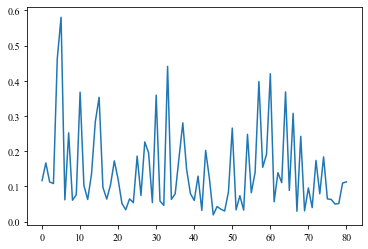

In [104]:
plt.plot(s_p.mean(axis=0))

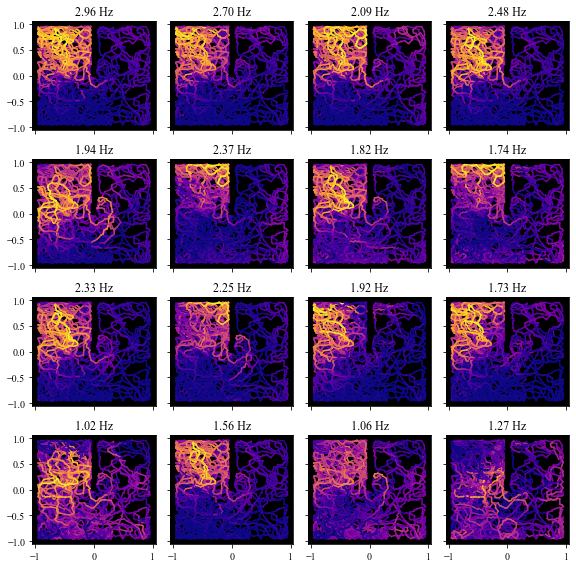

In [105]:
maxs = s_p.max(axis=0)
th = s_p.mean()
means = s_p.mean(axis=0)
# color = s_p / s_p.max(axis=1)[:, None] # w.r.t. time step
color = s_p / maxs[None, :] # w.r.t. maximal cellular response
color[np.isnan(color)] = 0

idx = np.argsort(means)[::-1]

figc = 4
figr = 4
fig, ax = plt.subplots(figr, figc, figsize=(figc*2, figr*2), sharex='all', sharey='all')

for counter, k in enumerate(idx[:figr * figc]):
    i, j = counter // figc, counter % figc
    ax[i, j].set_title('%.2f Hz' % maxs[k])
    ax[i, j].set_facecolor('black')
    for t in range(1000, s_p.shape[0]):
        c = plt.cm.plasma(color[t, k])
        ax[i, j].plot(x[t:t+2, 0],x[t:t+2, 1], color=c)
            
fig.tight_layout()

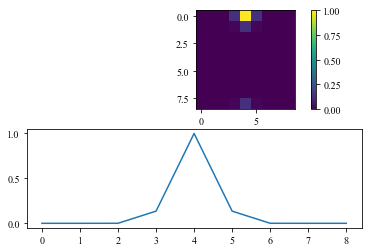

In [52]:
pc = Place(9, rank=len(alphas), tau=10, scale=0.5, a=20, b=2.5)
fig, ax = plt.subplots(2)
W = pc.W[4].reshape(pc.n, pc.n)
im = ax[0].imshow(W)
plt.colorbar(im, ax=ax[0])
ax[1].plot(W[0])

In [53]:
s = np.zeros((1000, 81))
A = 20
s[0] = np.random.rand(81) * 0.1 * A
I_ext = s.copy()
I_ext[:50, 40] = 1
I_ext[:50, 4] = 1
I_ext[550:600, 0] = 1
for t in range(1, 1000):
    I = (I_ext[t] * A + pc.W @ s[t-1]) / (1.5 * s[t-1].sum())
    s[t] = s[t-1] + (I**2 * A - s[t-1]) / 10

In [54]:
# plt.plot(s[:600, 40])   
# s.min(), s.max()

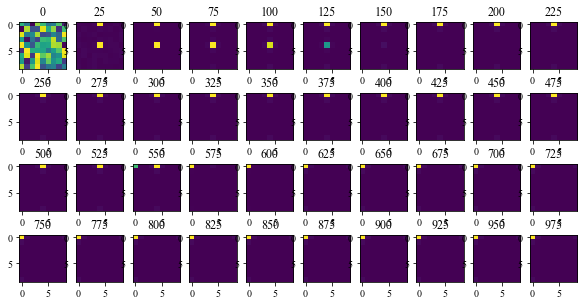

In [55]:
fig, ax = plt.subplots(4, 10, figsize=(10, 5))
for i, t in enumerate(range(0, 1000, 25)):
    ax[i//10, i%10].set_title(t)
    ax[i//10, i%10].imshow(s[t].reshape(9, 9))